<a href="https://colab.research.google.com/github/NBK-code/Demonstrations/blob/main/Linear_Reg_Stats_ML_Bayes_ways.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: http://marcelhaas.com/LinearRegression3ways.html

#A look at Linear Regression from three perspectives

There are three different perspectives to linear regression: 
1. "Traditional" statistical inference 
2. Machine learning 
3. Bayesian inference. 

The three are different in approach, methodology and interpretation, and understanding each of them will help us understand a lot about regression problems in general. The whole notebook also serves as a tutorial on linear regression, using three tools: statsmodels, scikit-learn and PyMC3. 

##Get Necessary Imports

In [ ]:
!pip install pymc3

In [3]:
# Imports
# Packages imported as a whole as well, so the print below lists all dependencies in the notebook
import sys
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics and machine learning
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression

# Bayesian statistics
import pymc3 as pm
import arviz as az

# Some plotting styles
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

print("This notebook uses the following packages (and versions):")
print("---------------------------------------------------------")
print("python", sys.version[:5])
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

This notebook uses the following packages (and versions):
---------------------------------------------------------
python 3.7.1
numpy 1.21.6
pandas 1.3.5
matplotlib 3.2.2
seaborn 0.11.2
statsmodels.api 0.12.2
sklearn 1.0.2
pymc3 3.11.5
arviz 0.12.1


##Create a Data Set

In [28]:
# Parameters about the data:
size = 20   # number of data points
true_intercept = 4
true_slope = 0.8

# Create the independent variable
x = np.linspace(0, 1, size)
# Create the independent variable y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise, drawn from a Gaussian (from numpy) with mean 0 and a standard deviation of 0.5
np.random.seed(123)
y = true_regression_line + np.random.normal(scale=0.1, size=size)

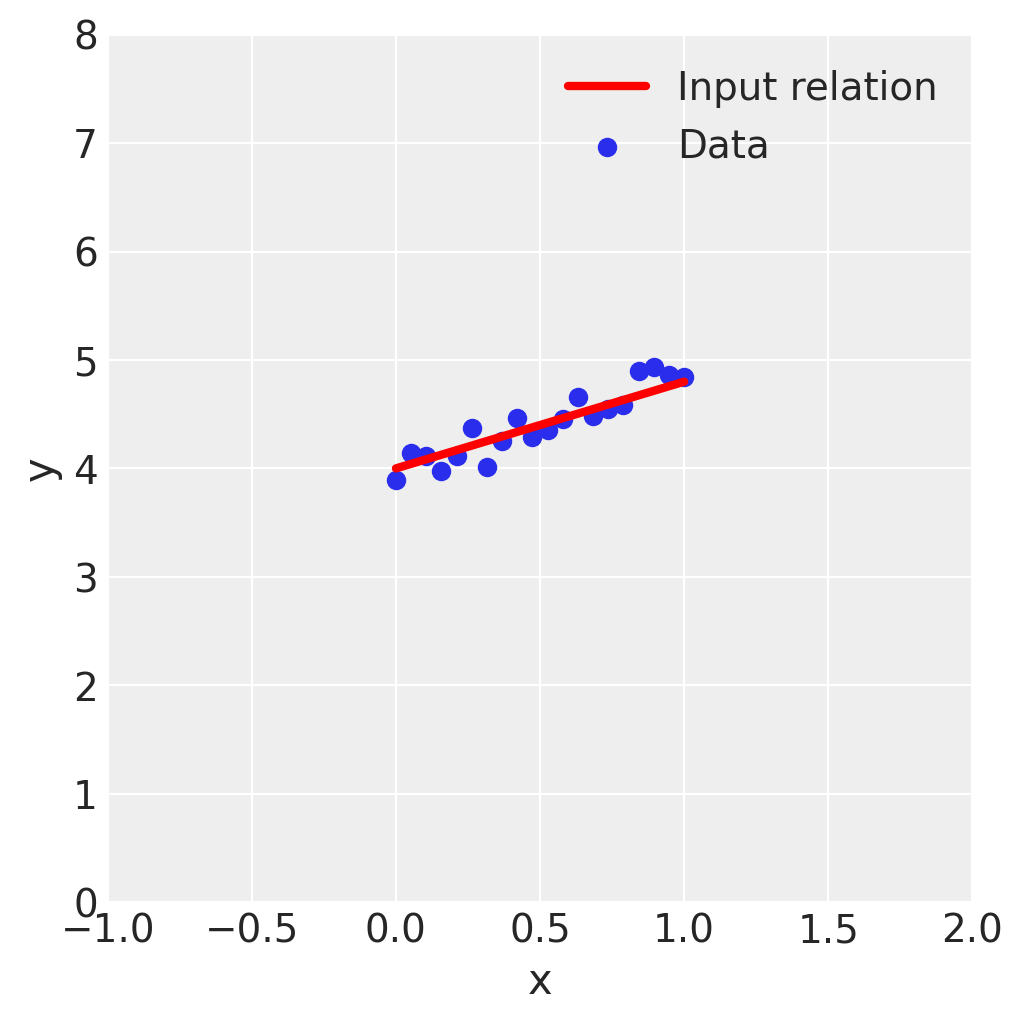

In [29]:
# Here's what it looks like (plotted the matplotlib interactive way)
plt.figure(figsize=(5,5))
plt.scatter(x, y, label='Data')
plt.plot(x, true_regression_line, color='red', linewidth=3, label='Input relation')
plt.legend()
plt.xlim(left = -1, right = 2)
plt.ylim(bottom = 0, top = 8)
plt.xlabel('x'); plt.ylabel('y');

##1. "Traditional" statistical inference

The way to do inference is to make a Maximum Likelihood Estimate (MLE), for example through Ordinary Least Squares (OLS). Let's do such a maximum likelihood point estimate of the slope and intercept using the popular package statsmodels. Statsmodels follows the nomenclature of statistics classes where machine learning is not in scope. In linear regression one has the choice to fit including an intercept, or without. The latter is the default.

In the code below, we specify an independent variable X, which are our values of the data x above, plus a constant (one constant, it has the same value for all x, but the value is as yet unknown). Then we perform an OLS regression for y on X. Note the somewhat archaic terminology of endogenous and exogenous variables.

In [30]:
# Statsmodels requires one to specify the extra constant that needs to be fitted and can then fit using Ordinary Least Squares
X = sm.add_constant(x, prepend=True)
smreg = sm.OLS(y, X)
smres = smreg.fit()
# After fitting, an extensive summary of fit results can be produced.
print(smres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     116.1
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           2.79e-09
Time:                        19:25:23   Log-Likelihood:                 15.115
No. Observations:                  20   AIC:                            -26.23
Df Residuals:                      18   BIC:                            -24.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9358      0.052     76.240      0.0

This summary tells you a lot about your data, and about the regression. The top left column is an overview of what has been performed when and on what kind of data. The top right column tells you about a bunch of goodness-of-fit statistics. These are helpful in judging whether you should trust this model at all, and they can be used to pick one model over another. In particular, let's briefly focus on R-squared. This number describes the fraction of the variance of the data (in 
y
) that is explained by the model. It compares the variance in 
y
 with the variance of the residuals.
$$R^2
=1-\frac{RSS}{TSS}$$
where RSS and TSS are the residual sum of squares and the total sum of squares, respectively. This number is 1 for a perfect model, close to but below one for a good linear reagression and close to zero for a linear regression that does not estimate 
y
 any better than just taking the average of all 
y
i
 of the data points. A value lower than 0 is strictly possible, but that means that the model somehow managed to increase the variance and that you might want to reconsider your modeling approach. Rule-of-thumb for decent models is that an 
$R^2
≳
0.7$
 is acceptable, and higher than 0.9 is a good model. A value lower than 0.7 should raise eyebrows and values below 0.5 indicate that another algortihm is probably better suited for the problem. The 'adjusted' variant is useful when comparing models with different numbers of degrees of freedom ('Df' in the top left).

The F-statistic, Log-Likelihood, AIC and BIC are other numerical measures of how well your model is constrained by the data and in case of multiple dependent variables can be used to select the most relevant regressors.

The lower part of the table whows you the actual fit results, starting with the two most relevant numbers: the intercept and the slope. As you can see, the input ('true') values are well recovered and the uncertainty (shown as a standard error, a P-value and a 95% confidence interval) is small. The remaining part of the table shows some additional statistics about the residuals. A value of zero for 'Omnibus' would be perfectly normally distributed residuals (which is in fact what we used to generate the data, but the data set isn't huge). The Omnibus value uses the Skew (a measure of asymmetry in the distribution, 0 is perfectly symmetric) and Kurtosis ('peakiness', with high numbers indicating few outliers) of the distribution of residuals.

The 'Durbin-Watson' score measures homoscedasticity: is the error distribution even over the data set, or not? Ideally this would be between 1 and 2 (so we seem to be just a little bit off!). 'Jarque-Bera' is another way of combining skew and kurtosis into a measure like omnibus. Finally, the 'Condition Number' can be used to assess multicollinearity when two or more independent variables are used.

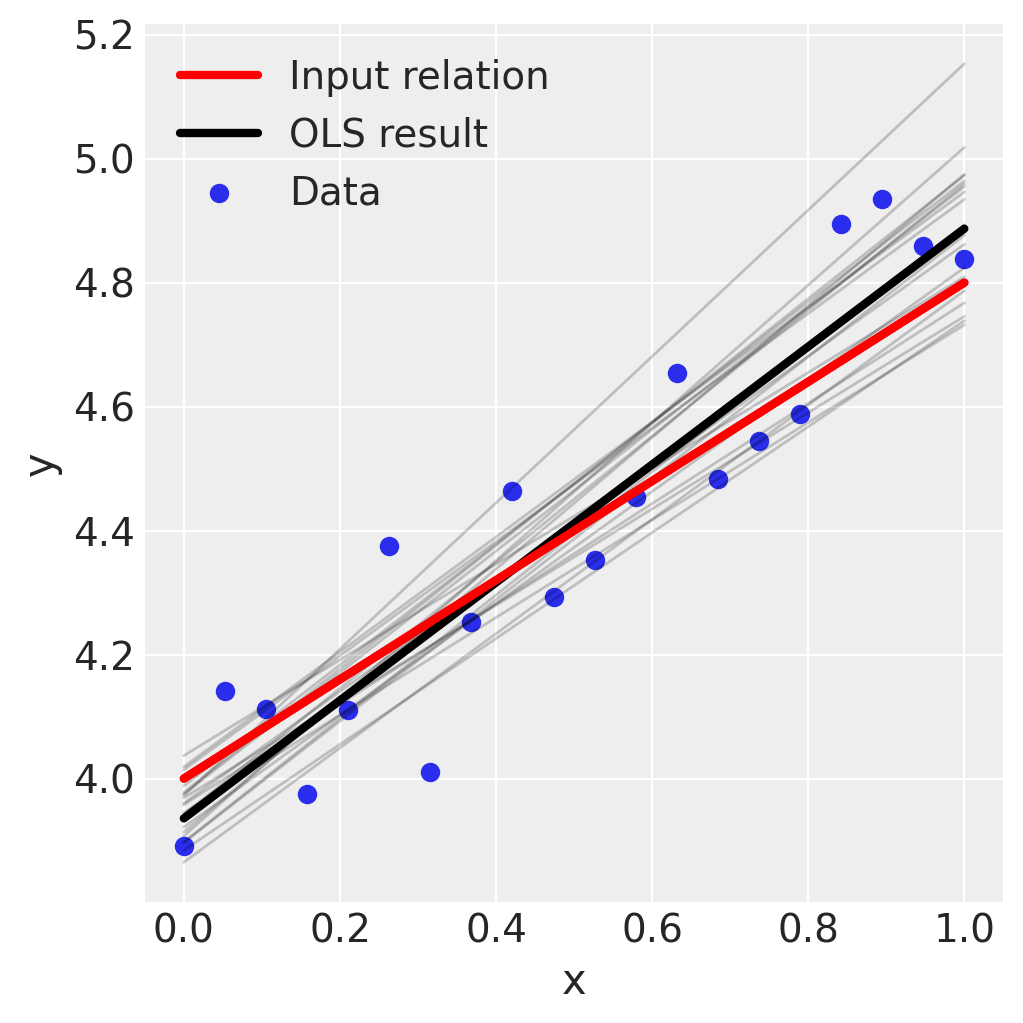

In [33]:
# %load solutions/statsmodels_results.py
# 1
best_fit = smres.predict(X)
plt.figure(figsize=(5,5))
plt.scatter(x, y, label='Data')
plt.plot(x, true_regression_line, color='red', linewidth=3, label='Input relation')
plt.plot(x, best_fit, color='black', linewidth=3, label='OLS result')
plt.legend()
plt.xlabel('x'); plt.ylabel('y');

# 2
for i in range(20):
    # Sample a Gaussian with the mean at the best fit and a standard deviation 
    # equal to the standard error of the fit results
    intercept = np.random.normal(loc=smres.params[0], scale=smres.bse[0])
    slope = np.random.normal(loc=smres.params[1], scale=smres.bse[1])
    # Draw it
    this_fit = intercept + x*slope
    plt.plot(x, this_fit, color='black', linewidth=1, alpha=0.2)
# Let's overplot the original once more, for visibility
# This could be done only once here, but some might choose to skip exercise 2
plt.plot(x, true_regression_line, color='red', linewidth=3);
